In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_confusion_matrix
import pickle


In [3]:
from IPython.display import display, HTML
datasets = pd.read_csv('semantic_reasoning.csv')
datasets.columns = ['shape1','shape2', 'dim1', 'dim2', 'dim3', 'GT']
datasets = datasets.sort_values('GT')
X = datasets.iloc[:, :5].values
Y = datasets.iloc[:, -1].values
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
             datasets.to_html() +
             "</div>"))
len(datasets)

X_Train_org  = X_Train
X_Test_org = X_Test
Y_Train_org  = Y_Train
Y_Test_org = Y_Test


,shape1,shape2,dim1,dim2,dim3,GT
0,0.033125,0.154169,0.025898,0.104020,0.082843,0
420,0.168500,0.261358,0.049884,0.095758,0.028454,0
419,0.094546,0.166437,0.101348,0.076508,0.094179,0
418,0.264960,0.297100,0.074546,0.079711,0.046499,0
417,0.293130,0.300898,0.050947,0.026549,0.048392,0
416,0.360528,0.258814,0.033445,0.092694,0.047672,0
415,0.261251,0.229477,0.067182,0.089675,0.041981,0
414,0.153481,0.129099,0.080457,0.034243,0.078983,0
413,0.196368,0.276367,0.066670,0.050107,0.048115,0
412,0.187954,0.220801,0.065850,0.069646,0.038302,0


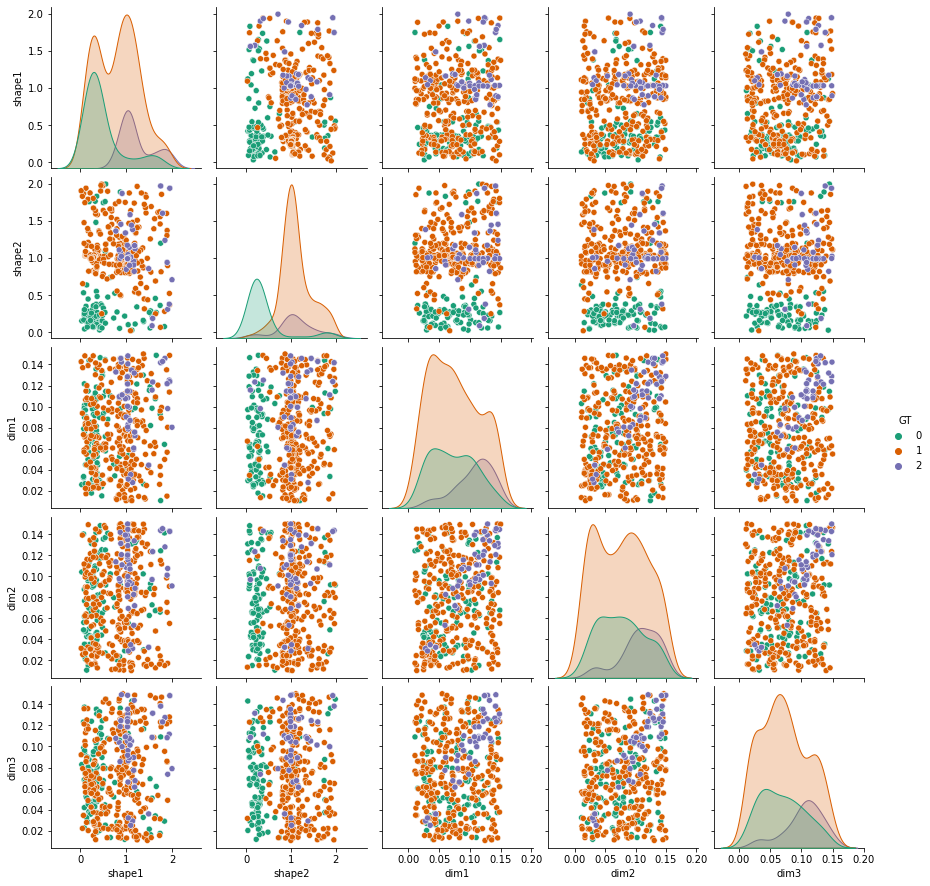

In [4]:
sns.pairplot(datasets,hue='GT',palette='Dark2')

In [6]:
# Data rescaling
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

# 1. Support Vector Machine (SVM)

In [7]:
svc = SVC()
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(X_Train, Y_Train)
print(grid_search.best_estimator_) 
print(grid_search.best_params_)

SVC(C=10, gamma=0.1)
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


### 1.1 SVM: Results training data

accuracy_score_test:  0.9703264094955489


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


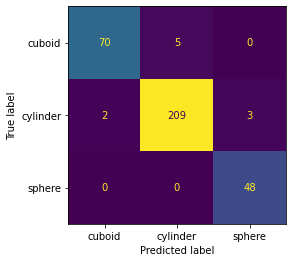

In [8]:
Y_pred_train = grid_search.predict(X_Train)
print('accuracy_score_test: ',accuracy_score(Y_Train, Y_pred_train))
# sns.heatmap(confusion_matrix(Y_Train, Y_pred_train), annot=True, fmt='d', cmap='YlGnBu')
plot_confusion_matrix(grid_search, X_Train, Y_Train, display_labels=np.array(["cuboid", "cylinder", "sphere"]), colorbar=False)  

### 1.2 SVM: Results test data (SVM)

accuracy_score_test:  0.9026548672566371


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


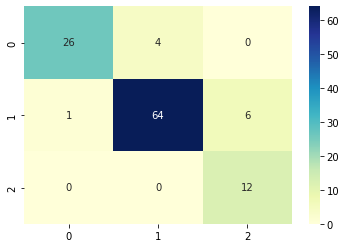

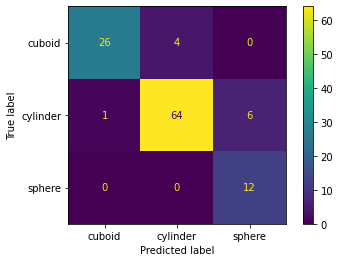

In [9]:
Y_pred_test = grid_search.predict(X_Test)
print('accuracy_score_test: ',accuracy_score(Y_Test, Y_pred_test))
sns.heatmap(confusion_matrix(Y_Test, Y_pred_test), annot=True, fmt='d', cmap='YlGnBu')
plot_confusion_matrix(grid_search, X_Test, Y_Test, display_labels=np.array(["cuboid", "cylinder", "sphere"]))  

In [10]:
print(classification_report(Y_Test,Y_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        30
           1       0.94      0.90      0.92        71
           2       0.67      1.00      0.80        12

    accuracy                           0.90       113
   macro avg       0.86      0.92      0.88       113
weighted avg       0.92      0.90      0.91       113



# 2. Multi-layer Perception (MLP)

In [11]:
from sklearn.neural_network import MLPClassifier
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=10000)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_Train, Y_Train) # X is train samples and y is the corresponding labels
print(clf.best_estimator_) 
print(clf.best_params_)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50),
              max_iter=10000)
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


### MLP: Results training data

accuracy_score_test:  1.0
AxesSubplot(0.125,0.125;0.62x0.755)


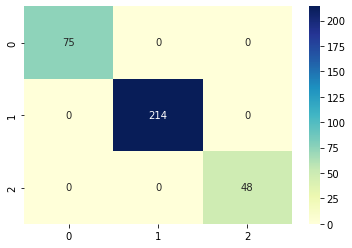

In [12]:
Y_pred_train_clf = clf.predict(X_Train)
print('accuracy_score_test: ',accuracy_score(Y_Train, Y_pred_train_clf))
print(sns.heatmap(confusion_matrix(Y_Train, Y_pred_train_clf), annot=True, fmt='d', cmap='YlGnBu'))

### MLP: Results test data

accuracy_score_test:  0.9203539823008849


/home/stanz/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


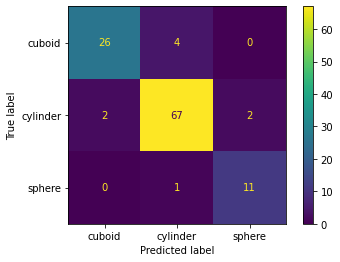

In [15]:
Y_pred_test_clf = clf.predict(X_Test)
print('accuracy_score_test: ',accuracy_score(Y_Test, Y_pred_test_clf))
# cm = sns.heatmap(confusion_matrix(Y_Test, Y_pred_test_clf), annot=True, fmt='d', cmap='YlGnBu')
cm = plot_confusion_matrix(clf, X_Test, Y_Test, display_labels=np.array(["cuboid", "cylinder", "sphere"]))  


In [17]:
import matplotlib.pyplot as plt 

cm.figure_.savefig("confusion_matrix.png")

In [191]:
print(classification_report(Y_Test,Y_pred_test_clf))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.94      0.94      0.94        71
           2       0.85      0.92      0.88        12

    accuracy                           0.93       113
   macro avg       0.91      0.92      0.91       113
weighted avg       0.93      0.93      0.93       113



# 3. Random Forest algorithm

In [192]:
from sklearn.ensemble import RandomForestClassifier
parameter_space = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier()
rf_grid_search = GridSearchCV(estimator=rf, param_grid=parameter_space, cv= 5)
rf_grid_search.fit(X_Train, Y_Train)
print(rf_grid_search.best_estimator_) 
print(rf_grid_search.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       n_estimators=500)
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}


accuracy_score_test:  1.0
AxesSubplot(0.125,0.125;0.62x0.755)


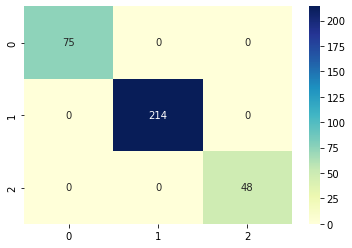

In [94]:
Y_pred_train_rf = rf_grid_search.predict(X_Train)
print('accuracy_score_test: ',accuracy_score(Y_Train, Y_pred_train_rf))
print(sns.heatmap(confusion_matrix(Y_Train, Y_pred_train_rf), annot=True, fmt='d', cmap='YlGnBu'))

<class 'numpy.ndarray'>
accuracy_score_test:  0.6283185840707964
AxesSubplot(0.125,0.125;0.62x0.755)


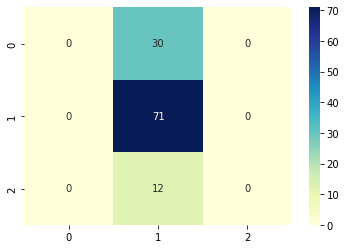

In [159]:
Y_pred_test_rf = rf_grid_search.predict(X_Test)
print('accuracy_score_test: ',accuracy_score(Y_Test, Y_pred_test_rf))
print(sns.heatmap(confusion_matrix(Y_Test, Y_pred_test_rf), annot=True, fmt='d', cmap='YlGnBu'))
plot_confusion_matrix(rf_grid_search, X_Test, Y_Test, display_labels=np.array(["cuboid", "cylinder", "sphere"]))  

In [96]:
print(classification_report(Y_Test,Y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.92      0.96      0.94        71
           2       0.91      0.83      0.87        12

    accuracy                           0.92       113
   macro avg       0.92      0.89      0.90       113
weighted avg       0.92      0.92      0.92       113



0.6678403755868545


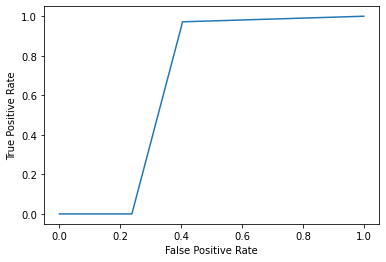

In [75]:
fpr, tpr, _ = roc_curve(Y_Test, Y_pred_test_rf, pos_label=clf.classes_[1])
print(auc(fpr, tpr))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# 4. Heuristic approach (logic-based approach)

In [155]:
def heuristic_function(Data):
    y_pred = []

    for shape in Data:
        if 0 <= shape[0] <= 0.7 and 0 <= shape[1] <= 0.7 and (-shape[0]-shape[1]+0.7) >= 0:
            y_pred.append(0)
        elif 0 <= shape[0] <= 0.7 and 1.3 <= shape[1] <= 2 and (shape[1]-shape[0]-1.3) >= 0: 
            y_pred.append(0)
        elif (-shape[1]-shape[0]+0.7) <= 0.7 and -shape[1] + shape[0] + 1.3 > 0 and not (0.9 < shape[0] < 1.1 and 0.9 < shape[1] < 1.1 and (max(shape[2:])/min(shape[2:]))<1.3):
            y_pred.append(1)
        elif 0.9 <= shape[0] <= 1.1 and 0.9 <= shape[1] <= 1.1 and (max(shape[2:])/min(shape[2:]))<1.3:
            y_pred.append(2)
        else: 
            y_pred.append(np.nan)
            print("for shape: ", shape, " no match found!!")
    return y_pred


accuracy_score_test:  0.771513353115727
AxesSubplot(0.125,0.125;0.62x0.755)


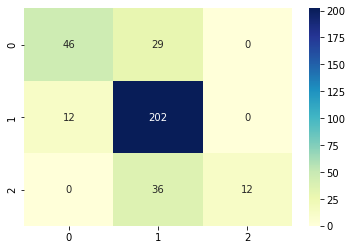

In [163]:
y_train_pred_heur = heuristic_function(X_Train_org[:,:5])
print('accuracy_score_test: ',accuracy_score(Y_Train, y_train_pred_heur))
print(sns.heatmap(confusion_matrix(Y_Train, y_train_pred_heur), annot=True, fmt='d', cmap='YlGnBu'))

accuracy_score_test:  0.8053097345132744
AxesSubplot(0.125,0.125;0.62x0.755)


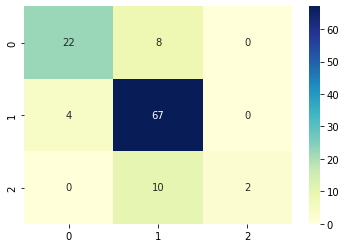

In [165]:
y_test_pred_heur = heuristic_function(X_Test_org[:,:5])
print('accuracy_score_test: ',accuracy_score(Y_Test, y_test_pred_heur))
print(sns.heatmap(confusion_matrix(Y_Test, y_test_pred_heur), annot=True, fmt='d', cmap='YlGnBu'))


In [166]:
print(classification_report(Y_Test,y_test_pred_heur))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79        30
           1       0.79      0.94      0.86        71
           2       1.00      0.17      0.29        12

    accuracy                           0.81       113
   macro avg       0.88      0.61      0.64       113
weighted avg       0.83      0.81      0.78       113



# SAVE ALGORITHMS!

In [168]:
# Save data

# Random Forest
# pickle.dump(rf_grid_search.best_estimator_, open('model_rf.pkl', 'wb'))

# MLP Algorithm
pickle.dump(clf.best_estimator_, open('model_mlp.pkl', 'wb'))

# SVM
# pickle.dump(grid_search.best_estimator_, open('model_svm.pkl', 'wb'))




In [ ]:
# Load data

# load
with open('model_svm.pkl', 'rb') as f:
    SVC_model = pickle.load(f)
result = int(SVC_model.predict([[1.0179203 , 0.93124332  ,0.02187232 , 0.02107734 , 0.02758151]]))

# result = int(SVC_model.predict([[0.102137575067499,	1.02867854047452	,0.333157138503882	,0.132167898866081,	0.025691348723388]]))
shapes = ['cuboid', 'cylinder', 'sphere']
print(result)
shapes[result]

